In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import time

In [2]:
from model_class.model_simply_traffic_lights import TrafficSimulation as sim

In [3]:
dic = '/home/james/masters/industrial_maths/Traffic_SpeedControls_IM_Project2/sim_data/' 

In [4]:
def calculate_mean_var(results_data):
    # allocate mem for speed.
    mean_values = [None]*len(results_data)
    var_values  = [None]*len(results_data) 
    # compute the mean and var for each batch.
    for i,data in enumerate(results_data):
        mean_values[i] = np.mean(data, axis=0)
        var_values[i] =np.var(data, axis=0) 
    return mean_values, var_values

In [6]:
###################################
### 1) road length #################
####################################
def road_length_sim( road_length):
    nt = 200
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    region_lengths = [14]*road_length  # only one speed limit everywhere
    densities = np.linspace(0, 1, 20)

    # not need but set empty 
    traffic_light_list = [] 

    # allocate mem for results to be returned
    flow_rate = np.zeros_like(densities)
    spi  = np.zeros_like(densities) 

    # run sim for the range of densities 
    for index,density in enumerate(densities): 
        ts = sim(region_lengths, traffic_light_list, density, car_slow_down_prob)
        spi_iter = np.zeros(nt)

        for i in range(nt): 
            spi_iter[i] = ts.get_step_spi() 
            ts.update() 
        
        #flow rate 
        flow_rate[index] = ts.data_laps/nt
        # spi 
        spi[index] = np.sum(spi_iter) / nt
    return flow_rate, spi

In [7]:
## road length run sims 
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)
start_time = time.time()
#
number_of_repeats = 2 # number of iteration for reruns, to compute mean and var, 
data_points  = 20 # np.linspace(0,1,20)
#
road_lengths = [20, 100, 450, 900, 2000]
N = len(road_lengths)
# allocate mem, based on the number of data point and number of repeats.
FR_road_length   = [np.zeros((number_of_repeats, data_points))]*N
SPI_road_length  = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( road_lengths): 
    # run multiprocessing
    flow, spi =  zip(*pool.map(road_length_sim, [n]*number_of_repeats))
    # reshape to np.array
    
    # reshape to np.array
    FR_road_length[i] = np.array(flow).reshape((number_of_repeats, data_points))
    SPI_road_length[i] = np.array(spi).reshape((number_of_repeats, data_points))


pool.close()
pool.join()
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Elapsed time: {int(minutes)} minutes and {int(seconds)} seconds")

Elapsed time: 23 minutes and 24 seconds


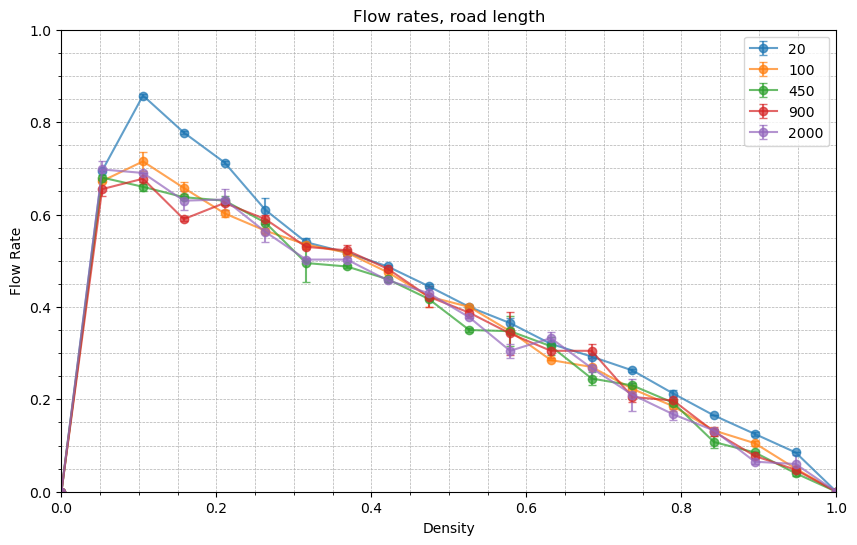

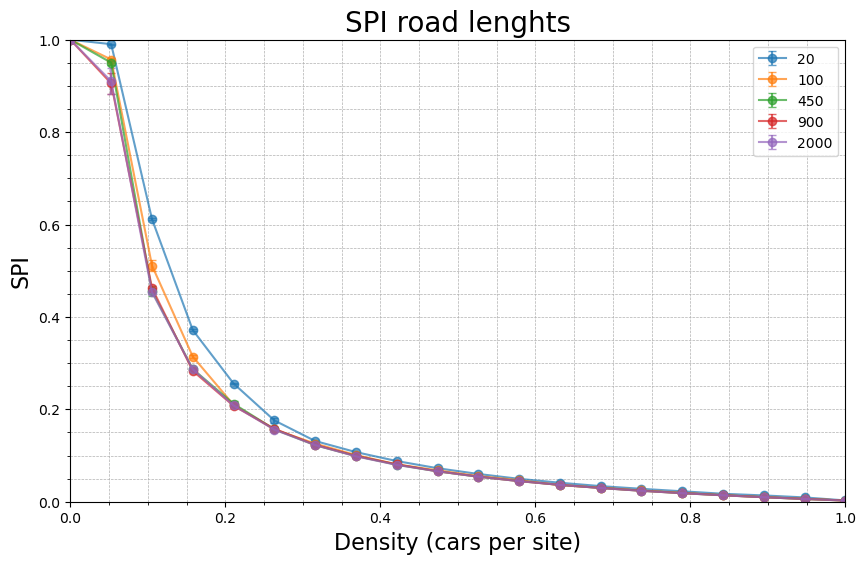

In [8]:
## test print road length 
means_fr,vars_fr = calculate_mean_var(FR_road_length)
means_spi,vars_spi = calculate_mean_var(SPI_road_length)

# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_fr):
    offset = 1#7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars_fr[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{road_lengths[i]}',capsize=3)
plt.title("Flow rates, road length")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_spi):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, data_points)[::offset], mean[::offset], yerr=np.sqrt( vars_spi[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{road_lengths[i]}',capsize=3)
plt.xlabel(f'Density (cars per site)', size=16)
plt.ylabel('SPI', size=16)
plt.title('SPI road lenghts',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [11]:
## save road lenght data 
file = 'road_len/'
# Saving each array to disk
for i, n in enumerate(road_lengths):
    np.save(f'{dic}{file}fr_{n}.npy', FR_road_length[i])
    np.save(f'{dic}{file}spi_{n}.npy', SPI_road_length[i])

# Time step 

In [14]:
###################################
### 2) time step  #################
####################################
def timestep_sim( step):
    nt = step
    road_length = 240
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    region_lengths = [14]*road_length  # only one speed limit everywhere
    densities = np.linspace(0, 1, 20)

    # not need but set empty 
    traffic_light_list = [] 

    # allocate mem for results to be returned
    flow_rate = np.zeros_like(densities)
    spi  = np.zeros_like(densities) 

    # run sim for the range of densities 
    for index,density in enumerate(densities): 
        ts = sim(region_lengths, traffic_light_list, density, car_slow_down_prob)
        spi_iter = np.zeros(nt)

        for i in range(nt): 
            spi_iter[i] = ts.get_step_spi() 
            ts.update() 
        
        #flow rate 
        flow_rate[index] = ts.data_laps/nt
        # spi 
        spi[index] = np.sum(spi_iter) / nt
    return flow_rate, spi

In [15]:
## time step run sims 
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)
start_time = time.time()
#
number_of_repeats = 10 # number of iteration for reruns, to compute mean and var, 
data_points  = 20 # np.linspace(0,1,20)
#
number_of_simulation_steps = [50,100,200,300] #,100] #,500,1000] # ,2500]
iter_var = number_of_simulation_steps
N = len(iter_var)
# allocate mem, based on the number of data point and number of repeats.
FR_time_step   = [np.zeros((number_of_repeats, data_points))]*N
SPI_time_step  = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( iter_var ): 
    # run multiprocessing
    flow, spi =  zip(*pool.map(timestep_sim, [n]*number_of_repeats))
    # reshape to np.array
    
    # reshape to np.array
    FR_time_step[i] = np.array(flow).reshape((number_of_repeats, data_points))
    SPI_time_step[i] = np.array(spi).reshape((number_of_repeats, data_points))

pool.close()
pool.join()
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Elapsed time: {int(minutes)} minutes and {int(seconds)} seconds")

Elapsed time: 5 minutes and 33 seconds


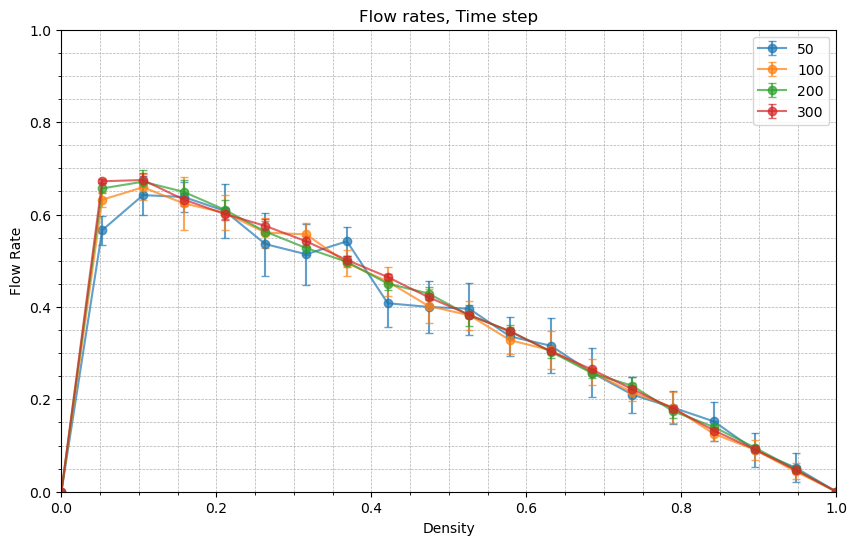

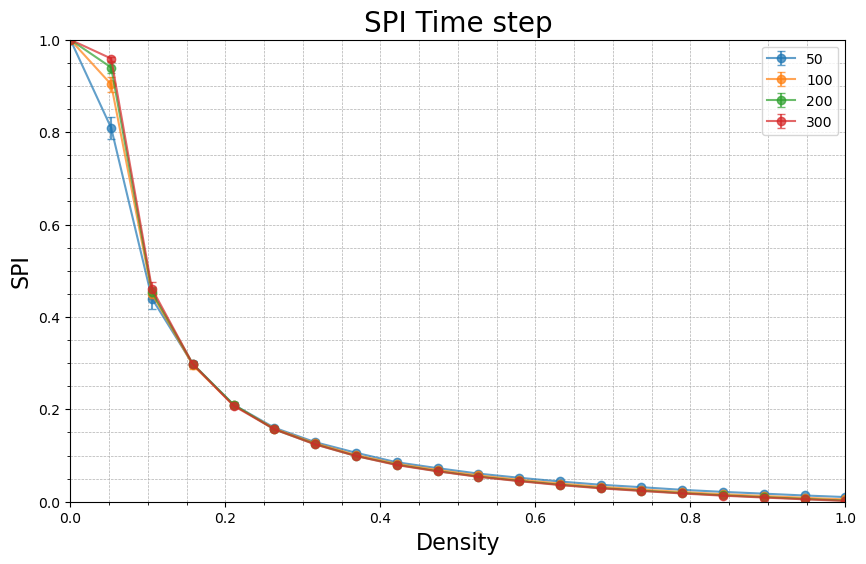

In [18]:
## test print time step  
means_fr,vars_fr = calculate_mean_var(FR_time_step)
means_spi,vars_spi = calculate_mean_var(SPI_time_step)
title = 'Time step'
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_fr):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars_fr[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.title(f"Flow rates, {title}")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_spi):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, data_points)[::offset], mean[::offset], yerr=np.sqrt( vars_spi[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.xlabel(f'Density', size=16)
plt.ylabel('SPI', size=16)
plt.title(f'SPI {title}',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [19]:
## save road lenght data 
file = 'time_step/'
# Saving each array to disk
for i, n in enumerate(iter_var):
    np.save(f'{dic}{file}fr_{n}.npy', FR_time_step[i])
    np.save(f'{dic}{file}spi_{n}.npy', SPI_time_step[i])

# probabilities

In [22]:
###################################
### 3) probabilities  #############
####################################
def prob_sim( prob ):
    nt = 200
    road_length = 240
    car_slow_down_prob = prob  # standard value for error from some paper (need ref)
    region_lengths = [14]*road_length  # only one speed limit everywhere
    densities = np.linspace(0, 1, 20)

    # not need but set empty 
    traffic_light_list = [] 

    # allocate mem for results to be returned
    flow_rate = np.zeros_like(densities)
    spi  = np.zeros_like(densities) 

    # run sim for the range of densities 
    for index,density in enumerate(densities): 
        ts = sim(region_lengths, traffic_light_list, density, car_slow_down_prob)
        spi_iter = np.zeros(nt)

        for i in range(nt): 
            spi_iter[i] = ts.get_step_spi() 
            ts.update() 
        
        #flow rate 
        flow_rate[index] = ts.data_laps/nt
        # spi 
        spi[index] = np.sum(spi_iter) / nt
    return flow_rate, spi

In [26]:
## time step run sims 
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)
start_time = time.time()
#
number_of_repeats = 10 # number of iteration for reruns, to compute mean and var, 
data_points  = 20 # np.linspace(0,1,20)
#
car_slow_down_prob = [0, 0.2, 0.4, 0.6, 0.8]
iter_var = car_slow_down_prob
N = len(iter_var)
# allocate mem, based on the number of data point and number of repeats.
FR_prob   = [np.zeros((number_of_repeats, data_points))]*N
SPI_prob = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( iter_var ): 
    # run multiprocessing
    flow, spi =  zip(*pool.map(prob_sim, [n]*number_of_repeats))
    # reshape to np.array
    
    # reshape to np.array
    FR_prob[i] = np.array(flow).reshape((number_of_repeats, data_points))
    SPI_prob[i] = np.array(spi).reshape((number_of_repeats, data_points))

pool.close()
pool.join()
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Elapsed time: {int(minutes)} minutes and {int(seconds)} seconds")

Elapsed time: 5 minutes and 11 seconds


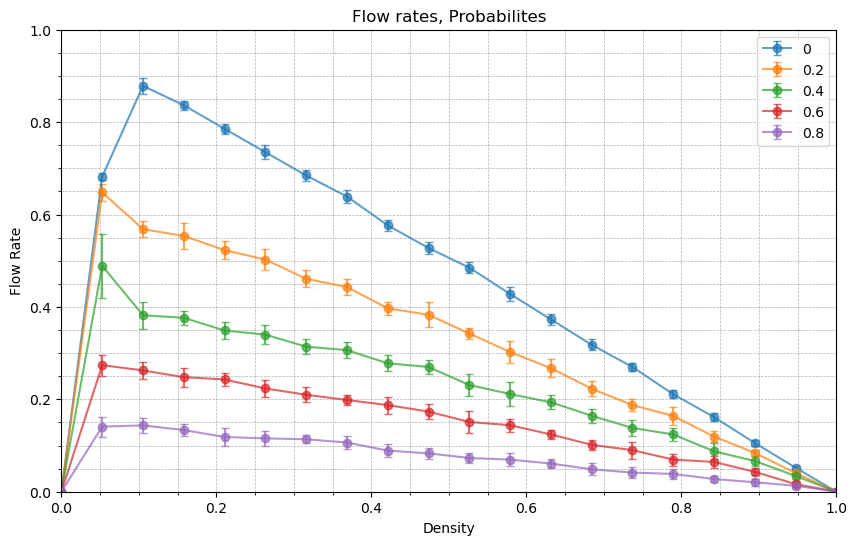

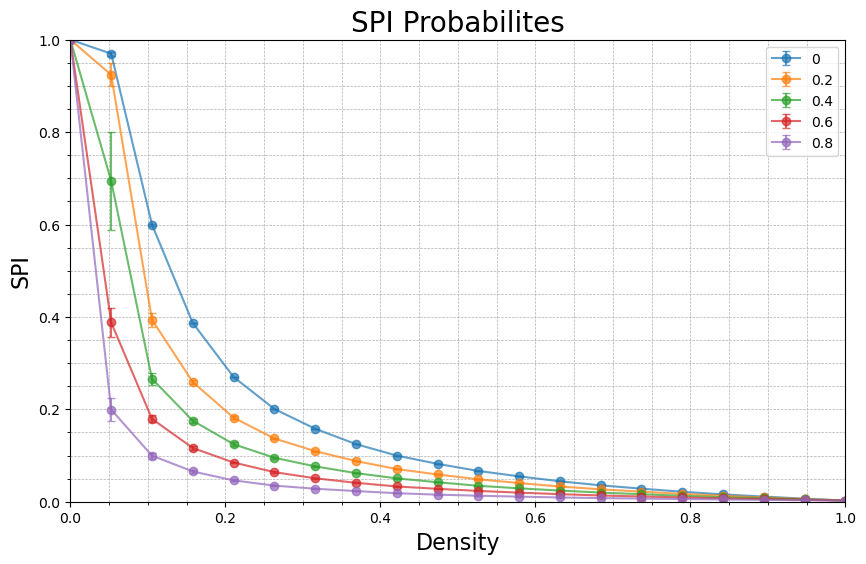

In [33]:
## test print time step  
means_fr,vars_fr = calculate_mean_var(FR_prob)
means_spi,vars_spi = calculate_mean_var(SPI_prob)
title = 'Probabilites'
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_fr):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars_fr[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.title(f"Flow rates, {title}")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_spi):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, data_points)[::offset], mean[::offset], yerr=np.sqrt( vars_spi[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.xlabel(f'Density', size=16)
plt.ylabel('SPI', size=16)
plt.title(f'SPI {title}',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [32]:
## save road lenght data 
file = 'prob/'
# Saving each array to disk
for i, n in enumerate(iter_var):
    np.save(f'{dic}{file}fr_{str(n).replace(".", "_")}.npy', FR_prob[i])
    np.save(f'{dic}{file}spi_{str(n).replace(".", "_")}.npy', SPI_prob[i])

# Traffic Light Simulations - red cycle times


In [9]:
###################################
### 4) red time     #############
####################################
def red_time( red_time ):
    nt = 200
    road_length = 240
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    region_lengths = [14]*road_length  # only one speed limit everywhere
    densities = np.linspace(0, 1, 20)

    # 
    starting_time = 0
    red_time = red_time
    green_time = red_time + 12
    light_positions = road_length // 2

    traffic_light_list = [(light_positions, green_time, red_time, starting_time, False)] 

    # allocate mem for results to be returned
    flow_rate = np.zeros_like(densities)
    spi  = np.zeros_like(densities) 

    # run sim for the range of densities 
    for index,density in enumerate(densities): 
        ts = sim(region_lengths, traffic_light_list, density, car_slow_down_prob)
        spi_iter = np.zeros(nt)

        for i in range(nt): 
            spi_iter[i] = ts.get_step_spi() 
            ts.update() 
        
        #flow rate 
        flow_rate[index] = ts.data_laps/nt
        # spi 
        spi[index] = np.sum(spi_iter) / nt
    return flow_rate, spi

In [10]:
## red time run sims 
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)
start_time = time.time()
#
number_of_repeats = 10 # number of iteration for reruns, to compute mean and var, 
data_points  = 20 # np.linspace(0,1,20)
#
red_time_list = np.linspace(2, 11, 5).astype(int)
iter_var = red_time_list
N = len(iter_var)
# allocate mem, based on the number of data point and number of repeats.
FR_red   = [np.zeros((number_of_repeats, data_points))]*N
SPI_red = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( iter_var ): 
    # run multiprocessing
    flow, spi =  zip(*pool.map(red_time, [n]*number_of_repeats))
    # reshape to np.array
    
    # reshape to np.array
    FR_red[i] = np.array(flow).reshape((number_of_repeats, data_points))
    SPI_red[i]= np.array(spi).reshape((number_of_repeats, data_points))

pool.close()
pool.join()
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Elapsed time: {int(minutes)} minutes and {int(seconds)} seconds")

Elapsed time: 5 minutes and 29 seconds


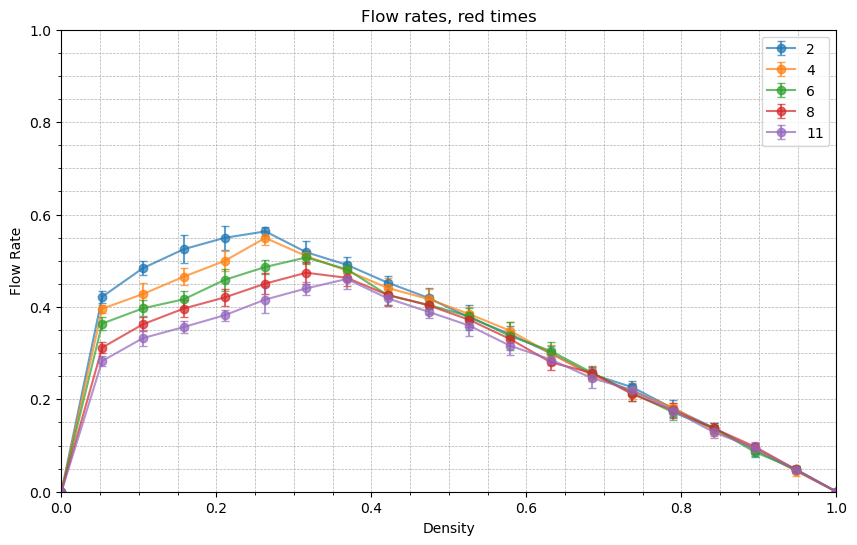

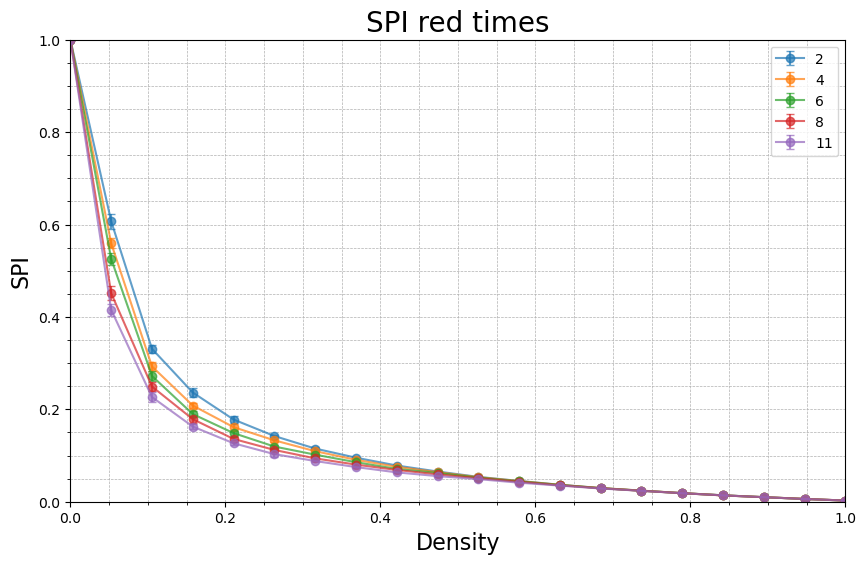

In [14]:
## test print time step  
means_fr,vars_fr = calculate_mean_var(FR_red)
means_spi,vars_spi = calculate_mean_var(SPI_red)
title = 'red times'
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_fr):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars_fr[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.title(f"Flow rates, {title}")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_spi):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, data_points)[::offset], mean[::offset], yerr=np.sqrt( vars_spi[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.xlabel(f'Density', size=16)
plt.ylabel('SPI', size=16)
plt.title(f'SPI {title}',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [13]:
## save road lenght data 
file = 'red_time/'
# Saving each array to disk
for i, n in enumerate(iter_var):
    np.save(f'{dic}{file}fr_{n}.npy', FR_red[i])
    np.save(f'{dic}{file}spi_{n}.npy', SPI_red[i])

# Green times

In [5]:
###################################
### 5) green time     #############
####################################
def green_time( green_time ):
    nt = 200
    road_length = 240
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    region_lengths = [14]*road_length  # only one speed limit everywhere
    densities = np.linspace(0, 1, 20)

    # 
    starting_time = 0
    red_time = 2
    green_time = green_time
    light_positions = road_length // 2

    traffic_light_list = [(light_positions, green_time, red_time, starting_time, False)] 

    # allocate mem for results to be returned
    flow_rate = np.zeros_like(densities)
    spi  = np.zeros_like(densities) 

    # run sim for the range of densities 
    for index,density in enumerate(densities): 
        ts = sim(region_lengths, traffic_light_list, density, car_slow_down_prob)
        spi_iter = np.zeros(nt)

        for i in range(nt): 
            spi_iter[i] = ts.get_step_spi() 
            ts.update() 
        
        #flow rate 
        flow_rate[index] = ts.data_laps/nt
        # spi 
        spi[index] = np.sum(spi_iter) / nt
    return flow_rate, spi

In [6]:
## green time run sims 
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)
start_time = time.time()
#
number_of_repeats = 10 # number of iteration for reruns, to compute mean and var, 
data_points  = 20 # np.linspace(0,1,20)
#
green_time_diff = np.linspace(10, 31, 5).astype(int) 
iter_var = green_time_diff
N = len(iter_var)
# allocate mem, based on the number of data point and number of repeats.
FR_green   = [np.zeros((number_of_repeats, data_points))]*N
SPI_green = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( iter_var ): 
    # run multiprocessing
    flow, spi =  zip(*pool.map(green_time, [n]*number_of_repeats))
    # reshape to np.array
    
    # reshape to np.array
    FR_green[i] = np.array(flow).reshape((number_of_repeats, data_points))
    SPI_green[i]= np.array(spi).reshape((number_of_repeats, data_points))

pool.close()
pool.join()
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Elapsed time: {int(minutes)} minutes and {int(seconds)} seconds")

Elapsed time: 5 minutes and 9 seconds


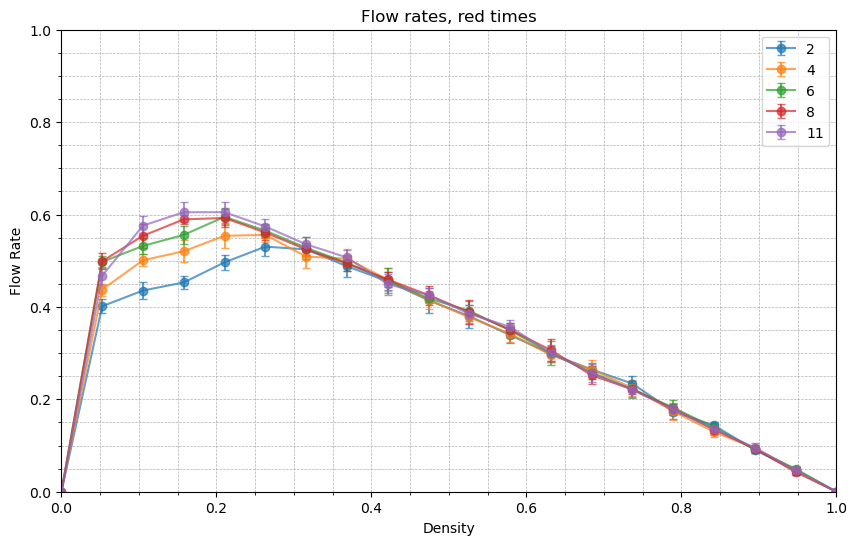

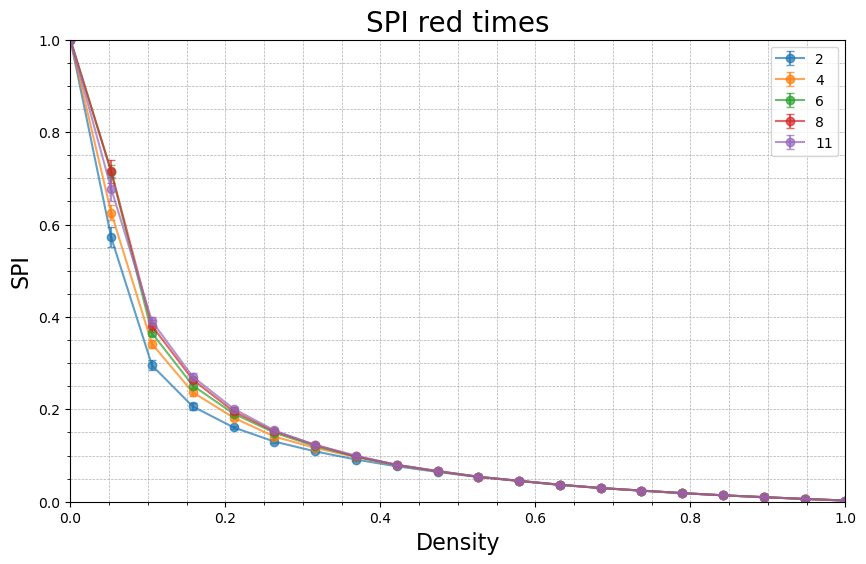

In [11]:
## test print time step  
means_fr,vars_fr = calculate_mean_var(FR_green)
means_spi,vars_spi = calculate_mean_var(SPI_green)
title = 'red times'
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_fr):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars_fr[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.title(f"Flow rates, {title}")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_spi):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, data_points)[::offset], mean[::offset], yerr=np.sqrt( vars_spi[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.xlabel(f'Density', size=16)
plt.ylabel('SPI', size=16)
plt.title(f'SPI {title}',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [15]:
## save road lenght data 
file = 'green_time/'
# Saving each array to disk
for i, n in enumerate(green_time_diff):
    np.save(f'{dic}{file}fr_{n}.npy', FR_green[i])
    np.save(f'{dic}{file}spi_{n}.npy', SPI_green[i])

# Speed limit boundaries

In [30]:
###################################
### speed limit boundaries ########
####################################
def speed_limit_boundaries( region_length_list):
    nt = 100
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    densities = np.linspace(0, 1, 20)
    #
    Region_speed_limits = [ [18], [14], [18]]
    road_list = (Region_speed_limits[0]* (region_length_list[0]))+ (Region_speed_limits[1]* (region_length_list[1]))+(Region_speed_limits[2]*(region_length_list[2]))
    
    # 
    starting_time = 0
    red_time = 2
    green_time = red_time + 12
    light_positions = len(road_list)//2


    traffic_light_list = [(light_positions, green_time, red_time, starting_time, False)] 

    # allocate mem for results to be returned
    flow_rate = np.zeros_like(densities)
    spi  = np.zeros_like(densities) 

    # run sim for the range of densities 
    for index,density in enumerate(densities): 
        ts = sim(road_list, traffic_light_list, density, car_slow_down_prob)
        spi_iter = np.zeros(nt)

        for i in range(nt): 
            spi_iter[i] = ts.get_step_spi() 
            ts.update() 
        
        #flow rate 
        flow_rate[index] = ts.data_laps/nt
        # spi 
        spi[index] = np.sum(spi_iter) / nt
    return flow_rate, spi

In [31]:
## speed limit sim
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)
start_time = time.time()
#
number_of_repeats = 5 # number of iteration for reruns, to compute mean and var, 
data_points  = 20 # np.linspace(0,1,20)
#
region_length_lists = [[214,0,214],[408,40,408],[388,80,388], [368, 120 ,368], [348, 160 ,348],[328, 200 ,328]]
iter_var = region_length_lists
N = len(iter_var)
# allocate mem, based on the number of data point and number of repeats.
FR_var_speed   = [np.zeros((number_of_repeats, data_points))]*N
SPI_var_speed = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( iter_var ): 
    # run multiprocessing
    flow, spi =  zip(*pool.map(speed_limit_boundaries, [n]*number_of_repeats))
    # reshape to np.array
    
    # reshape to np.array
    FR_var_speed[i] = np.array(flow).reshape((number_of_repeats, data_points))
    SPI_var_speed[i]= np.array(spi).reshape((number_of_repeats, data_points))

pool.close()
pool.join()
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Elapsed time: {int(minutes)} minutes and {int(seconds)} seconds")

Elapsed time: 9 minutes and 49 seconds


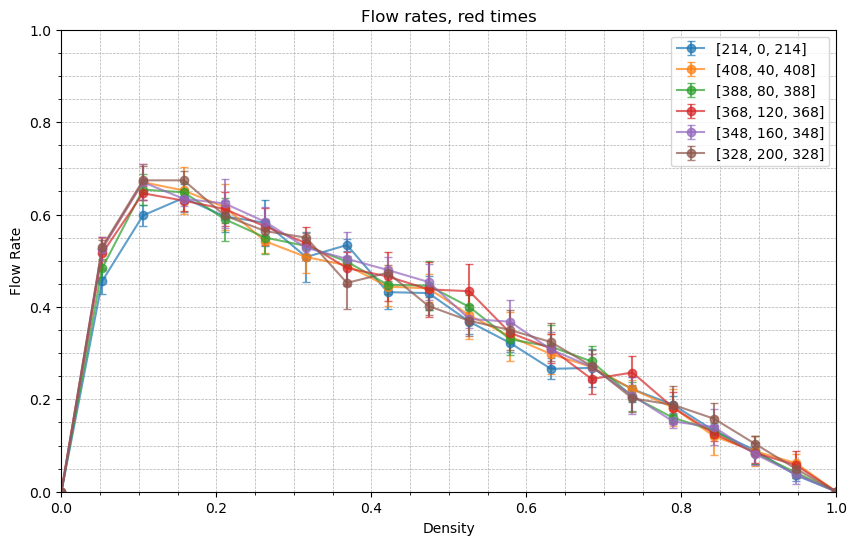

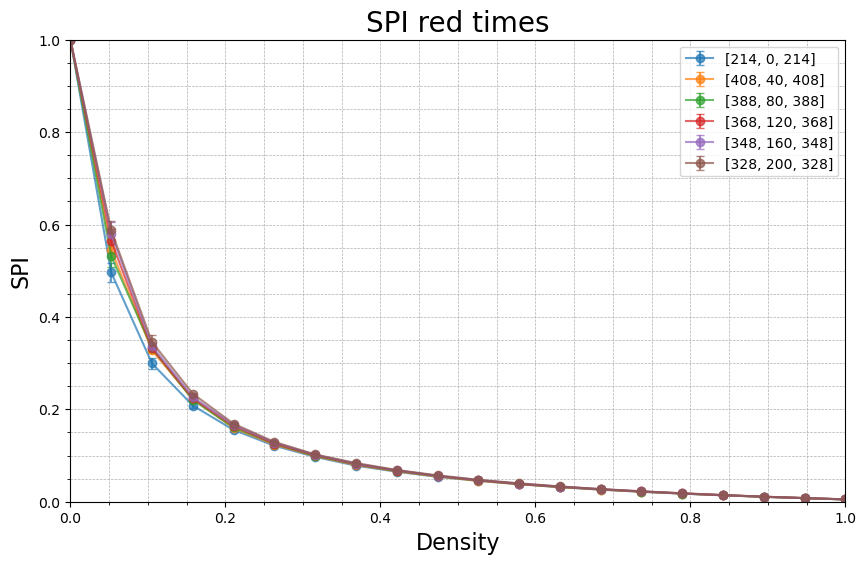

In [32]:
## test print time step  
means_fr,vars_fr = calculate_mean_var(FR_var_speed)
means_spi,vars_spi = calculate_mean_var(SPI_var_speed)
title = 'red times'
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_fr):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars_fr[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.title(f"Flow rates, {title}")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_spi):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, data_points)[::offset], mean[::offset], yerr=np.sqrt( vars_spi[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.xlabel(f'Density', size=16)
plt.ylabel('SPI', size=16)
plt.title(f'SPI {title}',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [28]:
## save road lenght data 
file = 'var_speed/'
# Saving each array to disk
for i, n in enumerate(iter_var):
    np.save(f'{dic}{file}fr_{n}.npy', FR_var_speed[i])
    np.save(f'{dic}{file}spi_{n}.npy', SPI_var_speed[i])

# Testing multiple traffic lights

In [37]:
###################################
### Multiple traffic light ########
####################################
def multiple_traffic_light( traffic_position ):
    nt = 100
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    densities = np.linspace(0, 1, 20)
    #
    region_lengths = [428]
    region_speed_limits = [14]
    road = [14]*428
        
    # 
    starting_time = 0
    red_time = 2
    green_time = red_time + 12

    traffic_light_list = [(position, green_time, red_time, starting_time, False) for position in traffic_position ] 

    # allocate mem for results to be returned
    flow_rate = np.zeros_like(densities)
    spi  = np.zeros_like(densities) 

    # run sim for the range of densities 
    for index,density in enumerate(densities): 
        ts = sim(road, traffic_light_list, density, car_slow_down_prob)
        spi_iter = np.zeros(nt)

        for i in range(nt): 
            spi_iter[i] = ts.get_step_spi() 
            ts.update() 
        
        #flow rate 
        flow_rate[index] = ts.data_laps/nt
        # spi 
        spi[index] = np.sum(spi_iter) / nt
    return flow_rate, spi

In [42]:
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)
start_time = time.time()
#
number_of_repeats = 5 # number of iteration for reruns, to compute mean and var, 
data_points  = 20 # np.linspace(0,1,20)
#
light_positions_list  =  [[214],
                       [107, 321],
                       [72, 215, 358] ,
                       [54, 161, 268, 375],
                       [43, 129, 215, 301, 387]]

iter_var = light_positions_list
N = len(iter_var)
# allocate mem, based on the number of data point and number of repeats.
FR_mul_tl   = [np.zeros((number_of_repeats, data_points))]*N
SPI_mul_tl  = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( iter_var ): 
    # run multiprocessing
    flow, spi =  zip(*pool.map(multiple_traffic_light, [n]*number_of_repeats))
    # reshape to np.array
    
    # reshape to np.array
    FR_mul_tl[i] = np.array(flow).reshape((number_of_repeats, data_points))
    SPI_mul_tl[i]= np.array(spi).reshape((number_of_repeats, data_points))

pool.close()
pool.join()
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Elapsed time: {int(minutes)} minutes and {int(seconds)} seconds")

Elapsed time: 5 minutes and 30 seconds


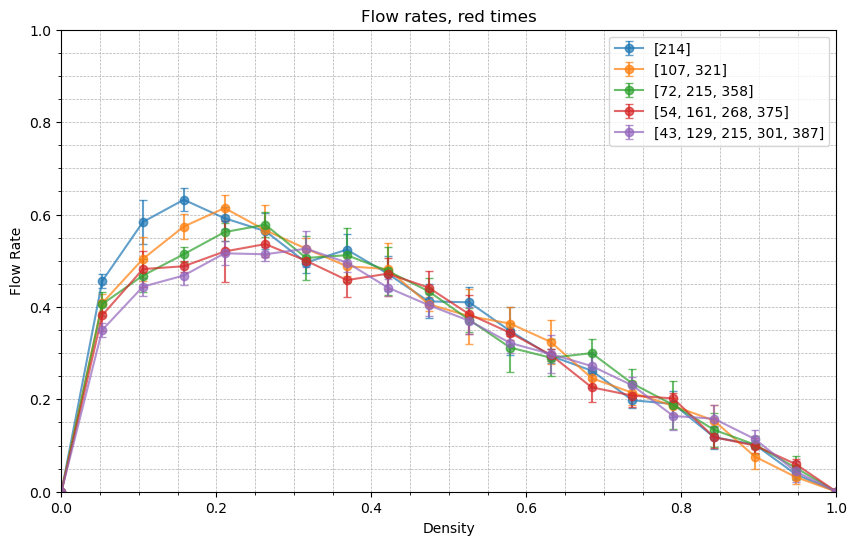

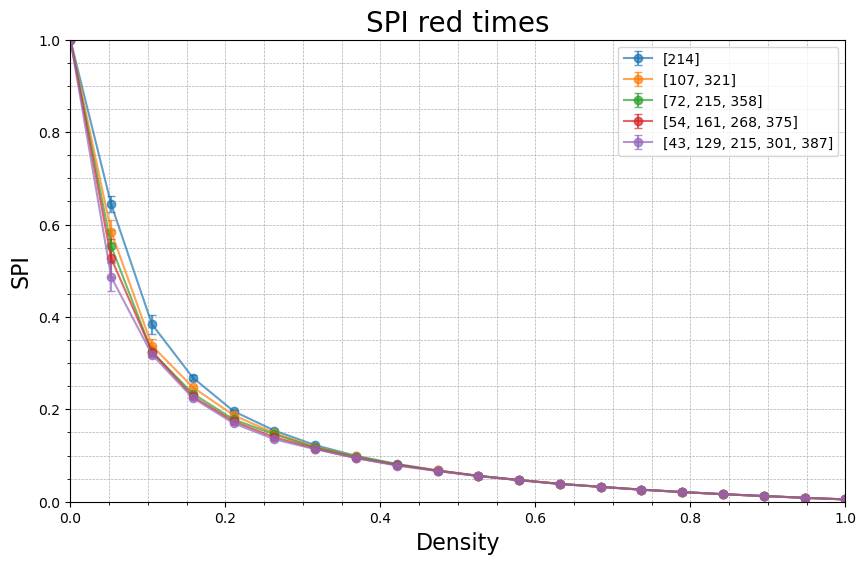

In [43]:
## test print time step  
means_fr,vars_fr = calculate_mean_var(FR_mul_tl)
means_spi,vars_spi = calculate_mean_var(SPI_mul_tl)
title = 'red times'
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_fr):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars_fr[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.title(f"Flow rates, {title}")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_spi):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, data_points)[::offset], mean[::offset], yerr=np.sqrt( vars_spi[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.xlabel(f'Density', size=16)
plt.ylabel('SPI', size=16)
plt.title(f'SPI {title}',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [44]:
## save road lenght data 
file = 'mul_tl/'
# Saving each array to disk
for i, n in enumerate(iter_var):
    np.save(f'{dic}{file}fr_{n}.npy', FR_mul_tl[i])
    np.save(f'{dic}{file}spi_{n}.npy', SPI_mul_tl[i])

#  base case One speed and no traffic 

In [52]:
###################################
### york road  428     ########
####################################
def ykrd_one_speed_no_light( x ):
    nt = 200
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    densities = np.linspace(0, 1, 20)
    #
    region_lengths = 428
    region_speed_limits = [14]
    road = region_speed_limits*region_lengths
        
    # 
    # starting_time = 0
    # red_time = 2
    # green_time = red_time + 12

    traffic_light_list = [] 

    # allocate mem for results to be returned
    flow_rate = np.zeros_like(densities)
    spi  = np.zeros_like(densities) 

    # run sim for the range of densities 
    for index,density in enumerate(densities): 
        ts = sim(road, traffic_light_list, density, car_slow_down_prob)
        spi_iter = np.zeros(nt)

        for i in range(nt): 
            spi_iter[i] = ts.get_step_spi() 
            ts.update() 
        
        #flow rate 
        flow_rate[index] = ts.data_laps/nt
        # spi 
        spi[index] = np.sum(spi_iter) / nt
    return flow_rate, spi

In [53]:
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)
start_time = time.time()
#
number_of_repeats = 20 # number of iteration for reruns, to compute mean and var, 
data_points  = 20 # np.linspace(0,1,20)
# dummy
light_positions_list  =  [1]

iter_var = light_positions_list
N = len(iter_var)
# allocate mem, based on the number of data point and number of repeats.
FR_yk_428   = [np.zeros((number_of_repeats, data_points))]*N
SPI_yk_428  = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( iter_var ): 
    # run multiprocessing
    flow, spi =  zip(*pool.map(ykrd_one_speed_no_light, [n]*number_of_repeats))
    # reshape to np.array
    
    # reshape to np.array
    FR_yk_428[i] = np.array(flow).reshape((number_of_repeats, data_points))
    SPI_yk_428[i]= np.array(spi).reshape((number_of_repeats, data_points))

pool.close()
pool.join()
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Elapsed time: {int(minutes)} minutes and {int(seconds)} seconds")

Elapsed time: 7 minutes and 50 seconds


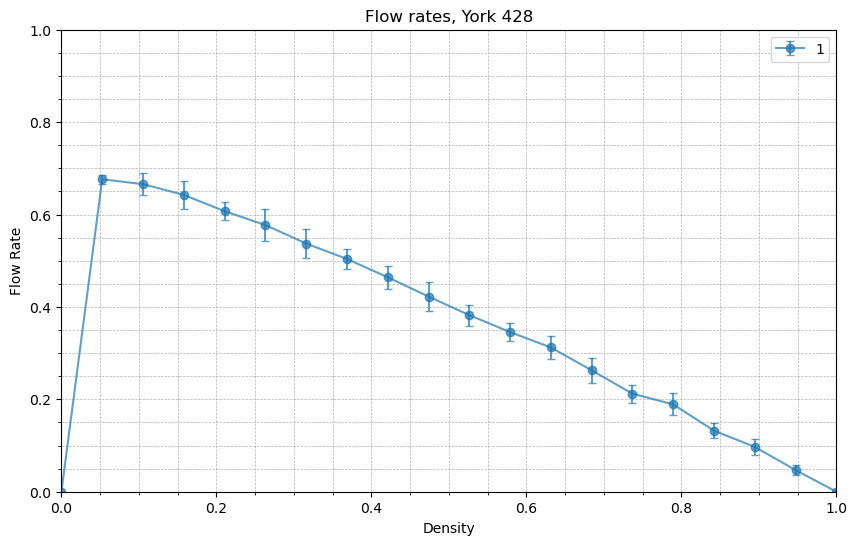

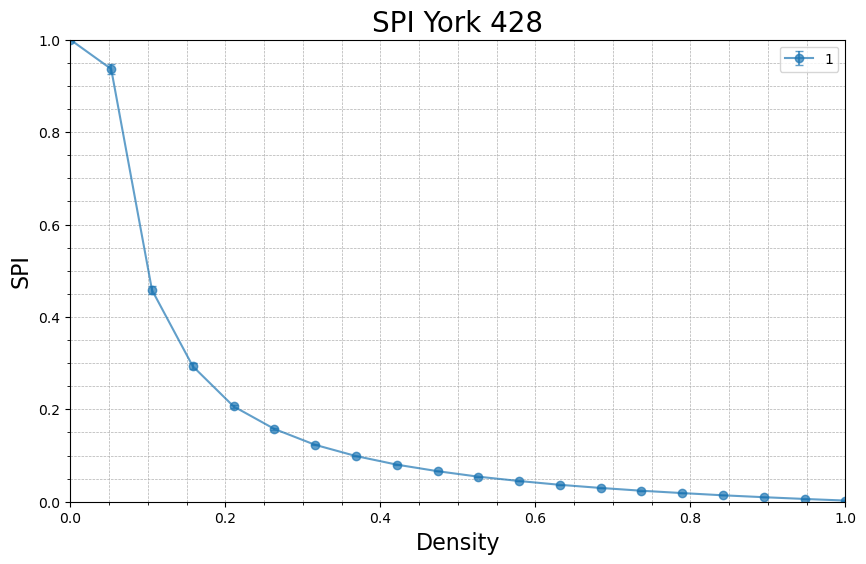

In [56]:
## test print time step  
means_fr,vars_fr = calculate_mean_var(FR_yk_428)
means_spi,vars_spi = calculate_mean_var(SPI_yk_428)
title = 'York 428'
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_fr):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars_fr[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.title(f"Flow rates, {title}")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_spi):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, data_points)[::offset], mean[::offset], yerr=np.sqrt( vars_spi[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.xlabel(f'Density', size=16)
plt.ylabel('SPI', size=16)
plt.title(f'SPI {title}',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [57]:
## save road lenght data 
file = 'yk_428/'
# Saving each array to disk
for i, n in enumerate(iter_var):
    np.save(f'{dic}{file}fr_{n}.npy', FR_yk_428[i])
    np.save(f'{dic}{file}spi_{n}.npy', SPI_yk_428[i])

# York road 240

In [58]:
###################################
### york road  240       ########
####################################
def ykrd_one_speed_no_light( x ):
    nt = 200
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    densities = np.linspace(0, 1, 20)
    #
    region_lengths = 240
    region_speed_limits = [14]
    road = region_speed_limits*region_lengths
        
    # 
    # starting_time = 0
    # red_time = 2
    # green_time = red_time + 12

    traffic_light_list = [] 

    # allocate mem for results to be returned
    flow_rate = np.zeros_like(densities)
    spi  = np.zeros_like(densities) 

    # run sim for the range of densities 
    for index,density in enumerate(densities): 
        ts = sim(road, traffic_light_list, density, car_slow_down_prob)
        spi_iter = np.zeros(nt)

        for i in range(nt): 
            spi_iter[i] = ts.get_step_spi() 
            ts.update() 
        
        #flow rate 
        flow_rate[index] = ts.data_laps/nt
        # spi 
        spi[index] = np.sum(spi_iter) / nt
    return flow_rate, spi

In [59]:
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)
start_time = time.time()
#
number_of_repeats = 20 # number of iteration for reruns, to compute mean and var, 
data_points  = 20 # np.linspace(0,1,20)
# dummy
light_positions_list  =  [1]

iter_var = light_positions_list
N = len(iter_var)
# allocate mem, based on the number of data point and number of repeats.
FR_yk_240   = [np.zeros((number_of_repeats, data_points))]*N
SPI_yk_240  = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( iter_var ): 
    # run multiprocessing
    flow, spi =  zip(*pool.map(ykrd_one_speed_no_light, [n]*number_of_repeats))
    # reshape to np.array
    
    # reshape to np.array
    FR_yk_240[i] = np.array(flow).reshape((number_of_repeats, data_points))
    SPI_yk_240[i]= np.array(spi).reshape((number_of_repeats, data_points))

pool.close()
pool.join()
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Elapsed time: {int(minutes)} minutes and {int(seconds)} seconds")

Elapsed time: 2 minutes and 14 seconds


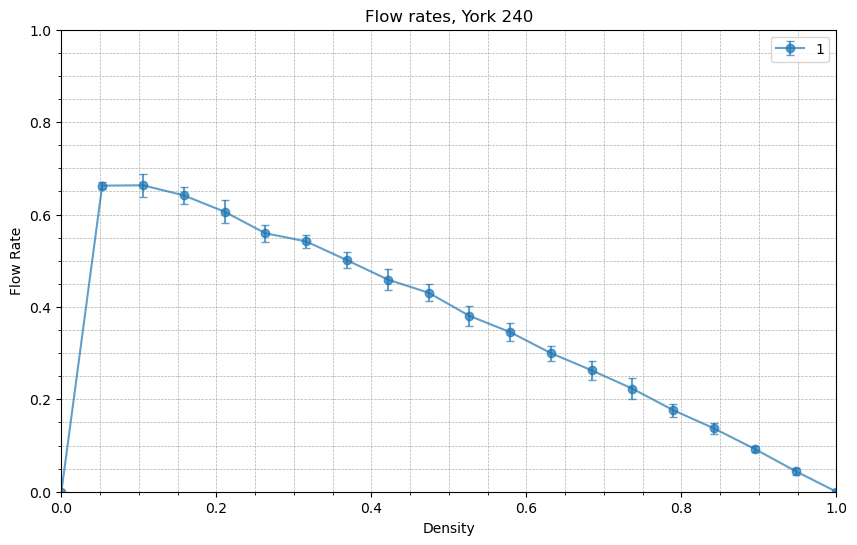

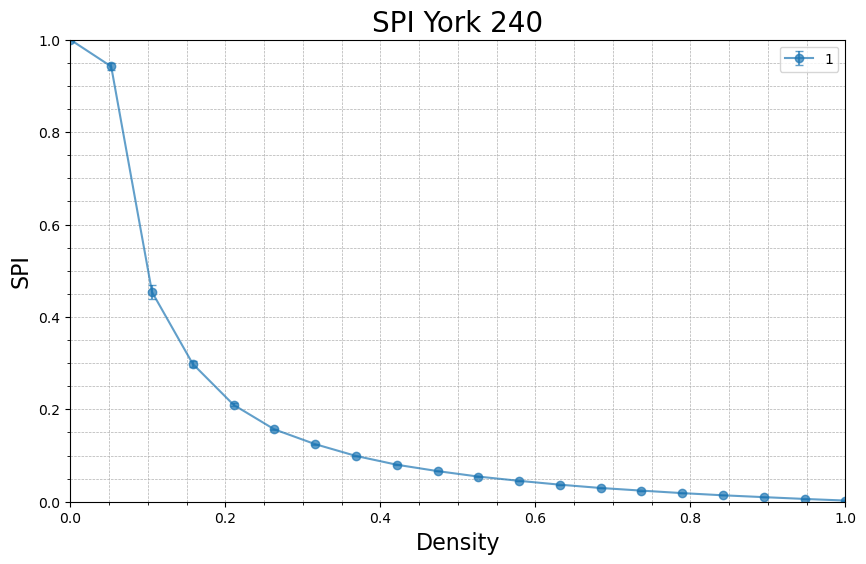

In [60]:
## test print time step  
means_fr,vars_fr = calculate_mean_var(FR_yk_240)
means_spi,vars_spi = calculate_mean_var(SPI_yk_240)
title = 'York 240'
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_fr):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars_fr[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.title(f"Flow rates, {title}")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_spi):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, data_points)[::offset], mean[::offset], yerr=np.sqrt( vars_spi[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.xlabel(f'Density', size=16)
plt.ylabel('SPI', size=16)
plt.title(f'SPI {title}',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [61]:
## save road lenght data 
file = 'yk_240/'
# Saving each array to disk
for i, n in enumerate(iter_var):
    np.save(f'{dic}{file}fr_{n}.npy', FR_yk_240[i])
    np.save(f'{dic}{file}spi_{n}.npy', SPI_yk_240[i])

# Varing TL position (1 TL )

In [62]:
###################################
###  Varing TL position    ########
####################################
def tl_var_pos( tl_pos ):
    nt = 200
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    densities = np.linspace(0, 1, 20)
    #
    region_lengths = 240
    region_speed_limits = [14]
    road = region_speed_limits*region_lengths
        
    # 
    starting_time = 0
    red_time = 2
    green_time = red_time + 12

    traffic_light_list = [(tl_pos, green_time, red_time, starting_time, False)] 

    # allocate mem for results to be returned
    flow_rate = np.zeros_like(densities)
    spi  = np.zeros_like(densities) 

    # run sim for the range of densities 
    for index,density in enumerate(densities): 
        ts = sim(road, traffic_light_list, density, car_slow_down_prob)
        spi_iter = np.zeros(nt)

        for i in range(nt): 
            spi_iter[i] = ts.get_step_spi() 
            ts.update() 
        
        #flow rate 
        flow_rate[index] = ts.data_laps/nt
        # spi 
        spi[index] = np.sum(spi_iter) / nt
    return flow_rate, spi

In [66]:
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)
start_time = time.time()
#
number_of_repeats = 20 # number of iteration for reruns, to compute mean and var, 
data_points  = 20 # np.linspace(0,1,20)
# dummy
varying_light_positions = np.linspace(0, 239, 5).astype(int)

iter_var = varying_light_positions
N = len(iter_var)
# allocate mem, based on the number of data point and number of repeats.
FR_var_tl   = [np.zeros((number_of_repeats, data_points))]*N
SPI_var_tl  = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( iter_var ): 
    # run multiprocessing
    flow, spi =  zip(*pool.map(tl_var_pos, [n]*number_of_repeats))
    # reshape to np.array
    
    # reshape to np.array
    FR_var_tl[i] = np.array(flow).reshape((number_of_repeats, data_points))
    SPI_var_tl[i]= np.array(spi).reshape((number_of_repeats, data_points))

pool.close()
pool.join()
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Elapsed time: {int(minutes)} minutes and {int(seconds)} seconds")

Elapsed time: 11 minutes and 6 seconds


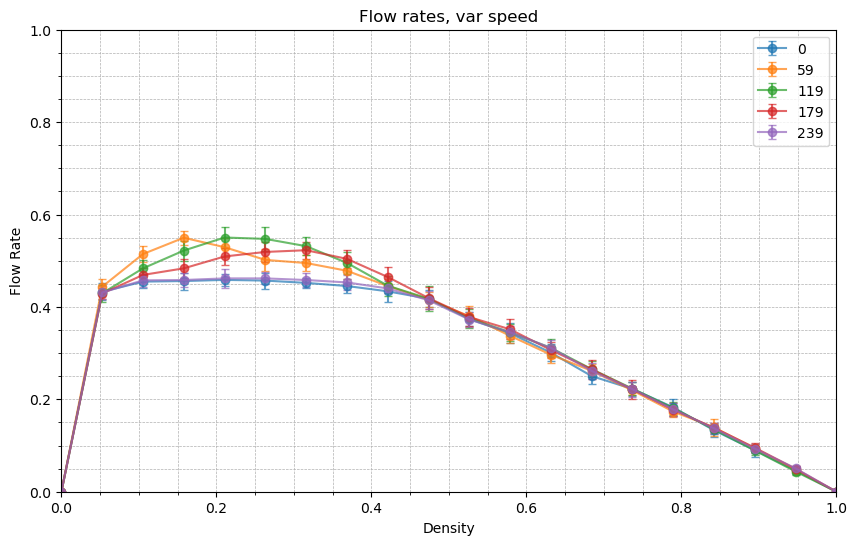

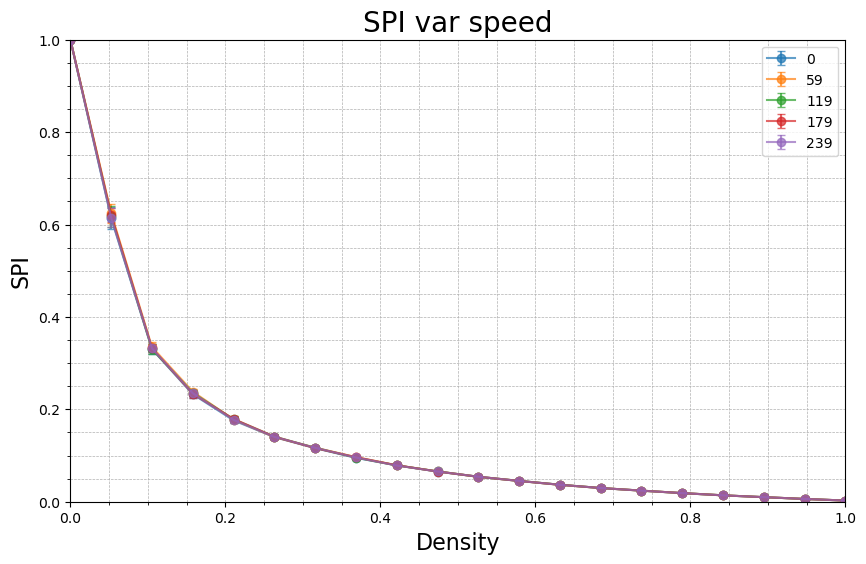

In [67]:
## test print time step  
means_fr,vars_fr = calculate_mean_var(FR_var_tl)
means_spi,vars_spi = calculate_mean_var(SPI_var_tl)
title = 'var speed'
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_fr):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars_fr[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.title(f"Flow rates, {title}")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means_spi):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, data_points)[::offset], mean[::offset], yerr=np.sqrt( vars_spi[i] )[::offset] , alpha=0.7, fmt='-o', label=f'{iter_var[i]}',capsize=3)
plt.xlabel(f'Density', size=16)
plt.ylabel('SPI', size=16)
plt.title(f'SPI {title}',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [68]:
## save road lenght data 
file = 'var_tl/'
# Saving each array to disk
for i, n in enumerate(iter_var):
    np.save(f'{dic}{file}fr_{n}.npy', FR_var_tl[i])
    np.save(f'{dic}{file}spi_{n}.npy', SPI_var_tl[i])